In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [3]:
def get_drift_files(config, root_dir):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDimsNS/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        print(file)
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
local_files

IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0127401bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0055348bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0891251bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
.DS_Store
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0222102bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0387196bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_067501bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0127401bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0511235bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0041919bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaray

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0041919bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0055348bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0073079bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_009649bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 

11.172482599614428 0.0041919 inf


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_98497/2722696646.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_98497/2722696646.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


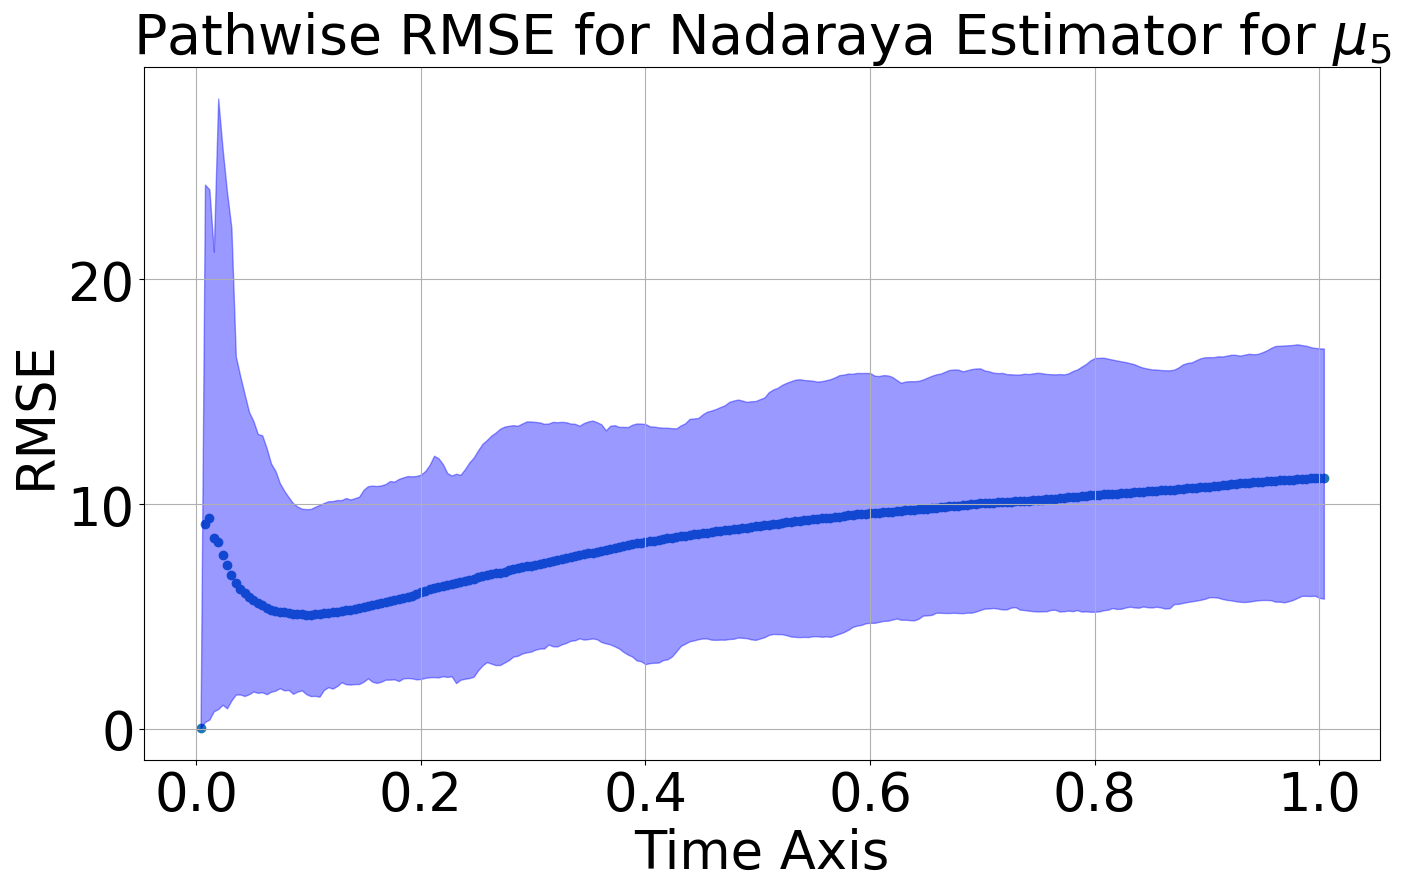

Final time cumulative MSE local-time error 11.172482599614428 with IQR ((5.791473629189191, 16.911770041684232))at bw 0.0041919

11.288992276809719 0.0055348 11.172482599614428
11.418857661181894 0.0073079 11.172482599614428
11.452450055224832 0.009649 11.172482599614428
11.490413940572155 0.0127401 11.172482599614428
11.26122706668524 0.0168214 11.172482599614428
11.117287699414609 0.0222102 11.172482599614428


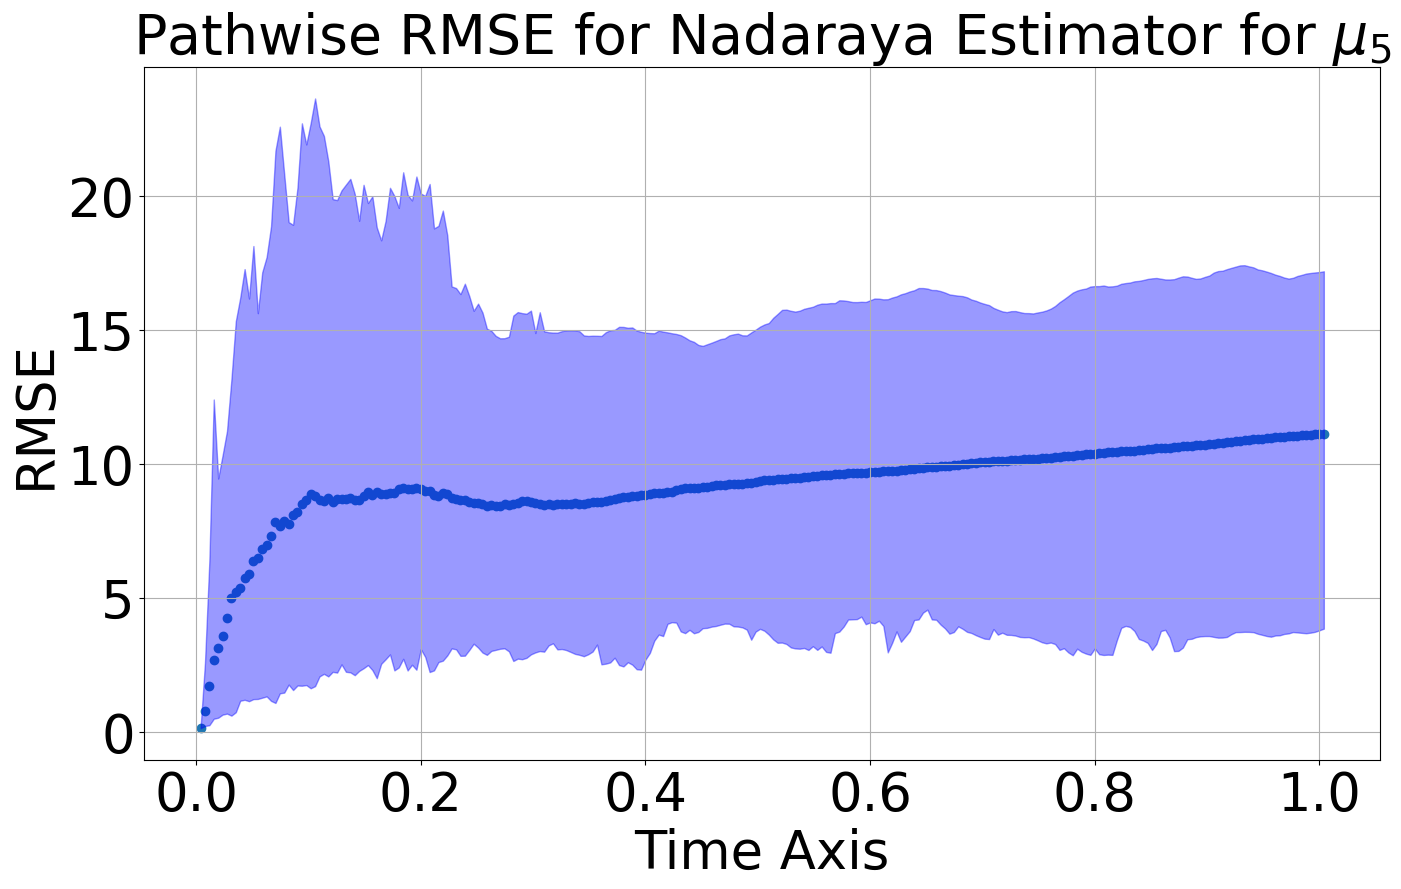

Final time cumulative MSE local-time error 11.117287699414609 with IQR ((3.846135522181471, 17.181929756641612))at bw 0.0222102

10.645566669774249 0.0293252 11.117287699414609


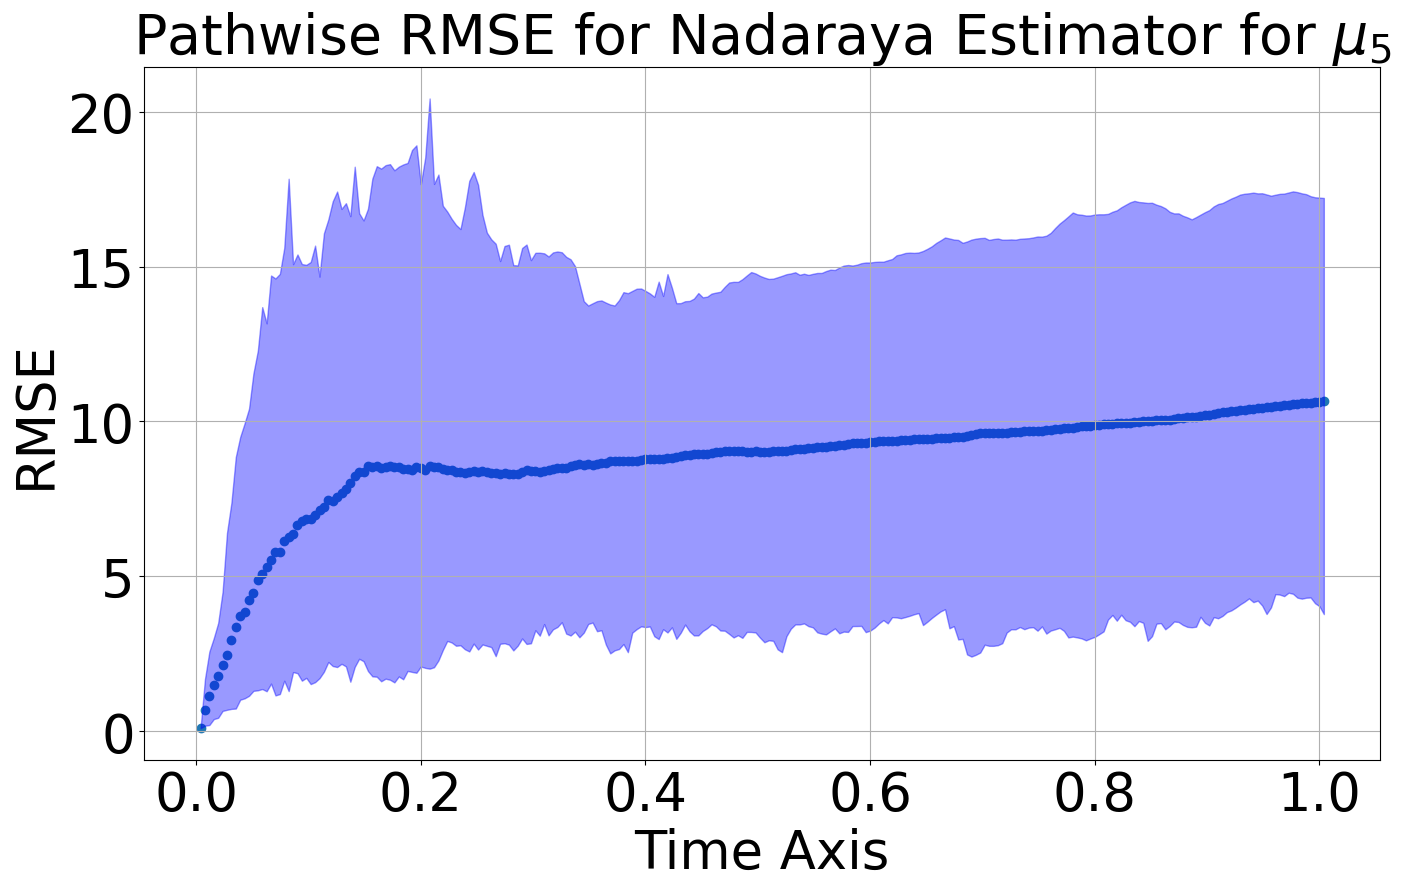

Final time cumulative MSE local-time error 10.645566669774249 with IQR ((3.7834612255984608, 17.211934304719303))at bw 0.0293252

9.918806199420457 0.0387196 10.645566669774249


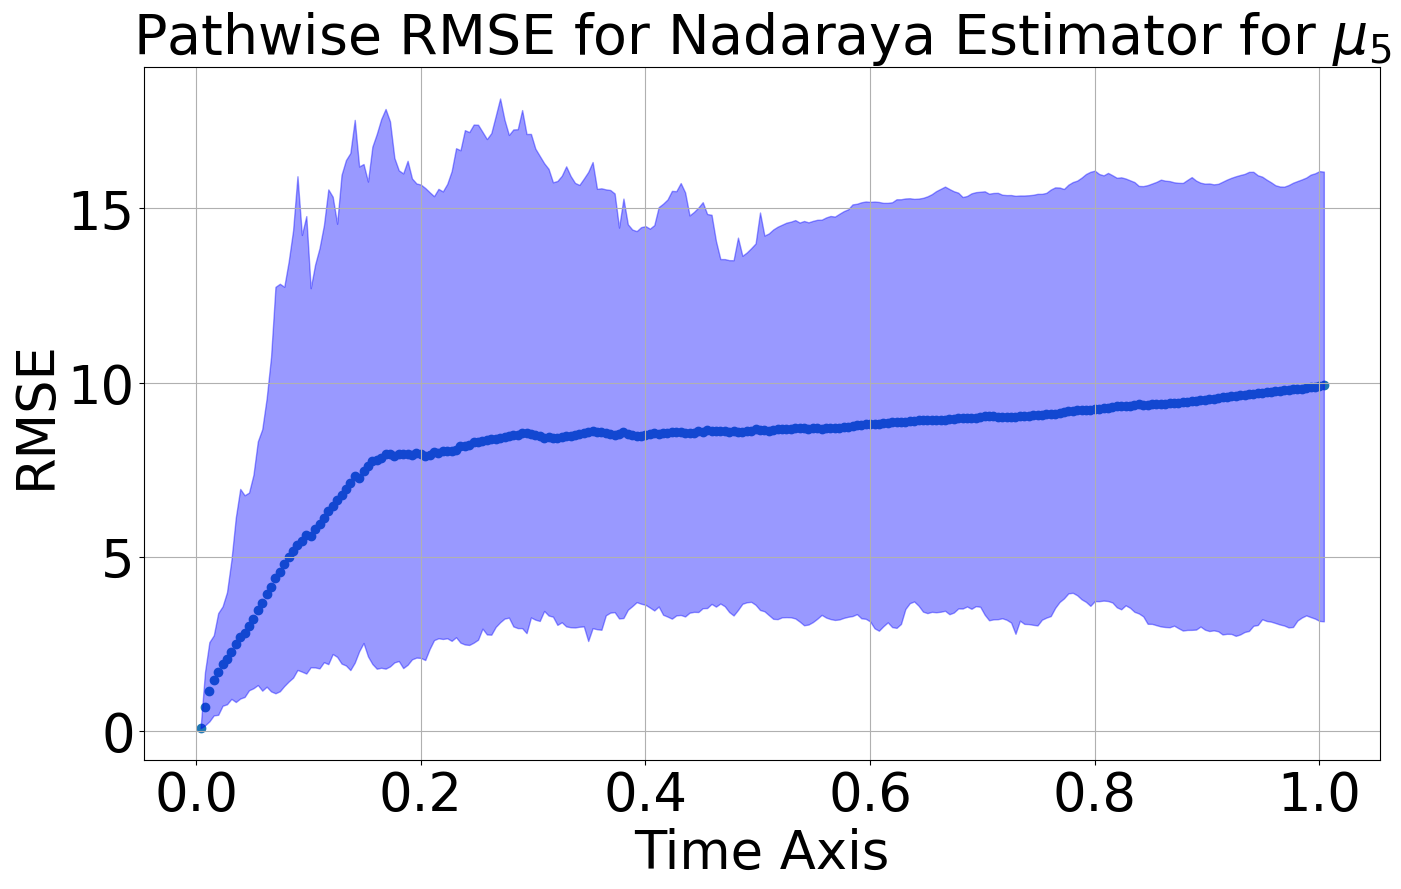

Final time cumulative MSE local-time error 9.918806199420457 with IQR ((3.1458873651354438, 16.055829358576197))at bw 0.0387196

9.427590121160218 0.0511235 9.918806199420457


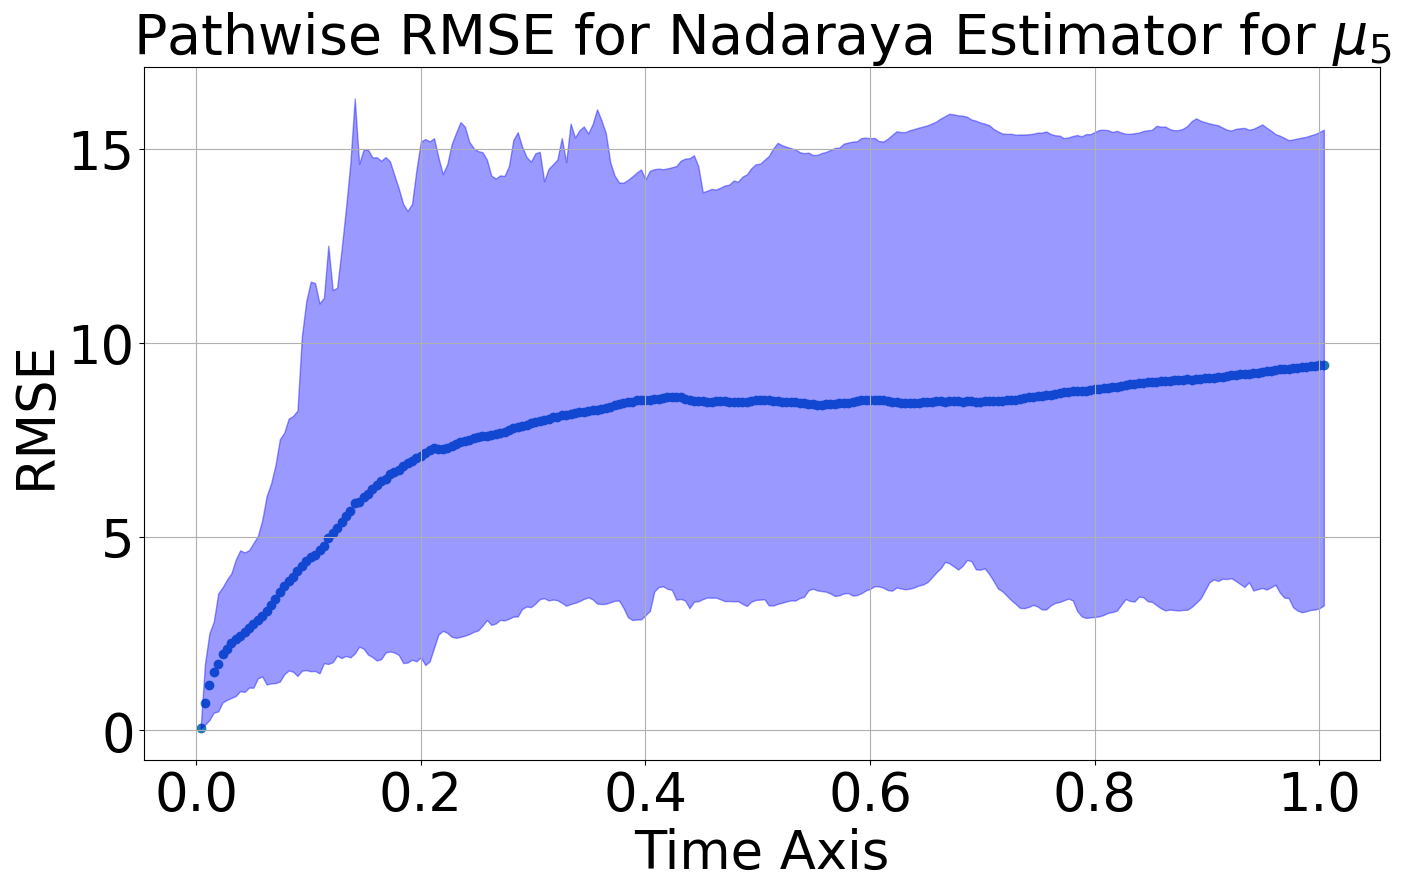

Final time cumulative MSE local-time error 9.427590121160218 with IQR ((3.223841331250186, 15.488523312724697))at bw 0.0511235

9.17151149451014 0.067501 9.427590121160218


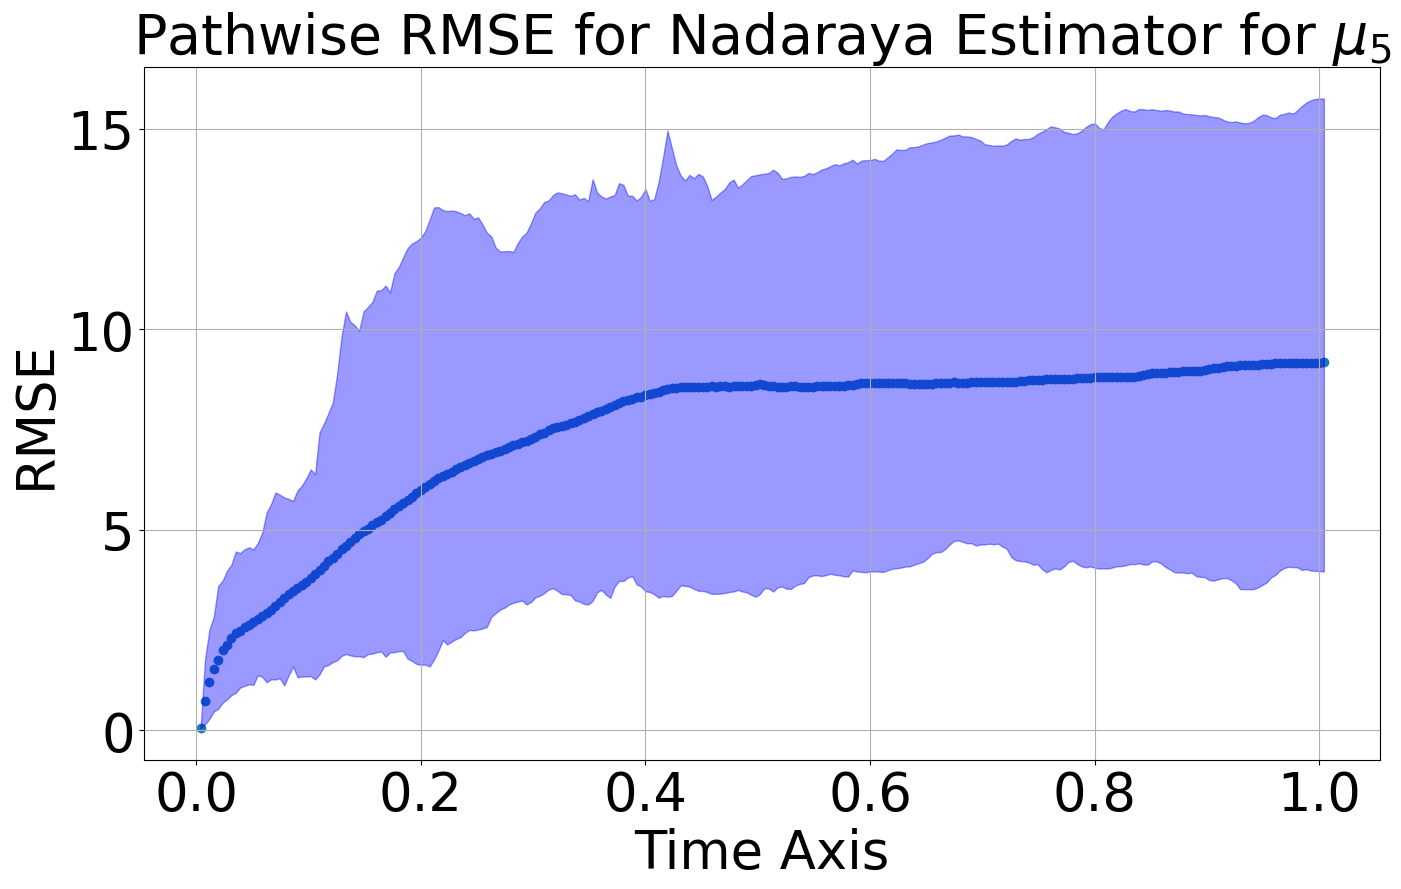

Final time cumulative MSE local-time error 9.17151149451014 with IQR ((3.9585510603978107, 15.758505809736626))at bw 0.067501

9.688217046391028 0.0891251 9.17151149451014


In [5]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/12DDimsNS/IIDNadaraya_fBiPot_{config.ndims}DDims_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw}\n")

In [6]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=True)
data

{'progress_name': 'idx',
 'span_units': 5.0,
 'wall_clock_h_total': 21.305059639745288,
 'wall_clock_per_unit_h': 4.261011927949058,
 'cpu_avg_pct': 1.9867394695787832,
 'cpu_peak_pct': 2.0,
 'ram_avg_gib': 190.48877827769107,
 'ram_peak_gib': 236.05704,
 'gpu_util_avg_pct': None,
 'gpu_util_peak_pct': None,
 'gpu_mem_avg_gib': None,
 'gpu_mem_peak_gib': None}